In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.molecule_dataset as molecule_dataset
import feature.graph_conversions as graph_conversions
import model.discrete_diffusers as discrete_diffusers
import model.generate as generate
import model.gnn as gnn
import model.util as model_util
import analysis.graph_metrics as graph_metrics
import analysis.mmd as mmd
import torch
import torch_geometric
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the data loader

In [3]:
# Create the data loader for training
dataset = molecule_dataset.ZINCDataset(connectivity_only=True)
data_loader = torch_geometric.loader.DataLoader(
    dataset, batch_size=32, shuffle=True, num_workers=0  # TODO: allow multi-processing
)

### Import the model

In [4]:
# Create the diffuser and model
diffuser = discrete_diffusers.BernoulliSkipDiffuser(100, 10, (1,))  # Make input shape just 1
t_limit = 1000

base_path = "/gstore/data/resbioai/tsenga5/discrete_graph_diffusion/models/trained_models"
model_path = os.path.join(base_path, "zinc-conn_edge-flip", "1", "last_ckpt.pth")

model = model_util.load_model(gnn.GraphLinkGAT, model_path).to(DEVICE)

### Show generated graphs

In [5]:
def sample_prior():
    """
    Samples from the prior distribution. Returns a batch as a Data object.
    """
    data = next(iter(data_loader))
    edges = graph_conversions.pyg_data_to_edge_vector(data)
    sampled_edges = diffuser.sample_prior(
        edges.shape[0], # Samples will be E x 1
        torch.tile(torch.tensor([t_limit], device=DEVICE), edges.shape)
    )[:, 0]  # Shape: E
    data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, sampled_edges)
    return data

In [6]:
ATOM_COLORS = {
    "C": "gray",
    "O": "lightcoral",
    "N": "royalblue"
}
ATOM_SYMBOLS = ["C", "N", "O", "F", "S", "Cl", "Br", "I", "P"]

def plot_molecule(mol_graph):
    colors, symbols = [], {}
    for node in mol_graph.nodes():
        symbol_index = np.where(mol_graph.nodes[node]["feats"])[0][0]
        symbol = ATOM_SYMBOLS[symbol_index]
        try:
            colors.append(ATOM_COLORS[symbol])
        except KeyError:
            colors.append("violet")
        symbols[node] = symbol
    nx.draw(
        mol_graph,
        pos=nx.nx_pydot.graphviz_layout(mol_graph),
        labels=symbols,
        with_labels=True,
        node_color=colors,
        node_size=500
    )
    plt.show()

In [7]:
# Take the trained model and go backwards to sample some graphs
print("Sampling some reverse trajectories")
prior = sample_prior()
samples = generate.generate_graph_samples(
    model, diffuser, prior, t_limit=t_limit, verbose=True
)
graphs = graph_conversions.split_pyg_data_to_nx_graphs(samples)

Sampling some reverse trajectories


100%|████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 15.89it/s]


0


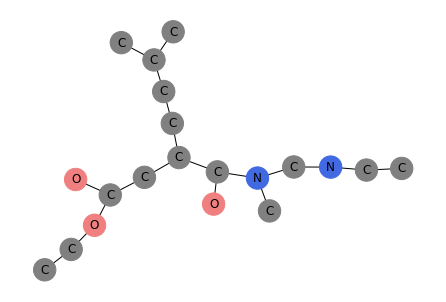

1


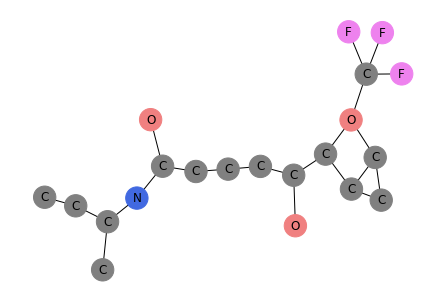

2


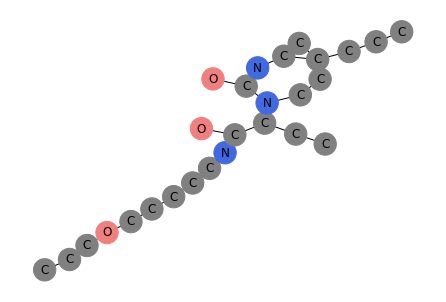

3


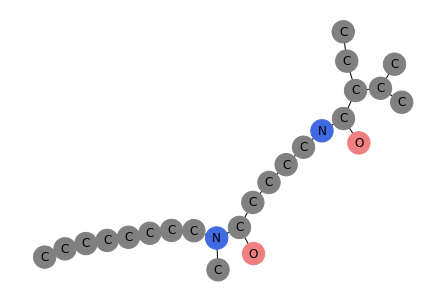

4


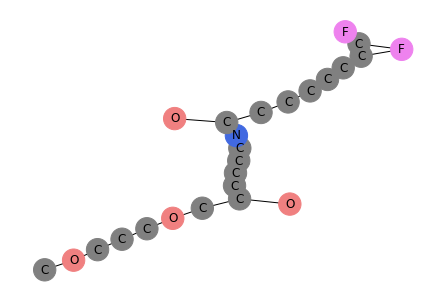

5


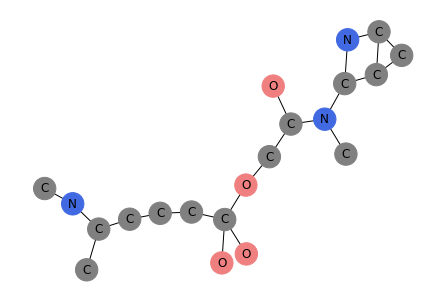

6


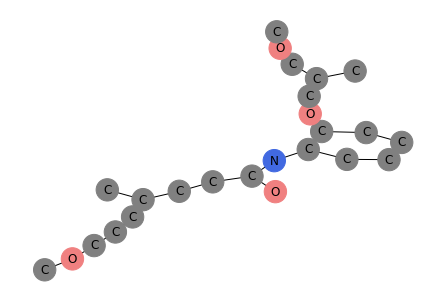

7


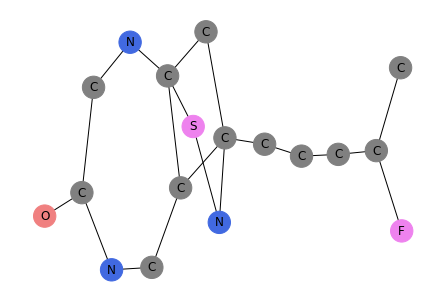

8


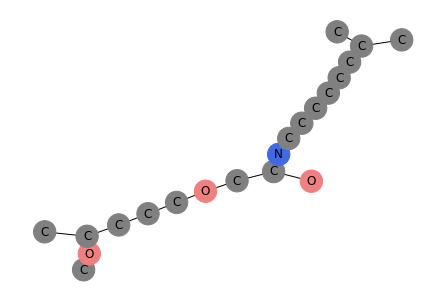

9


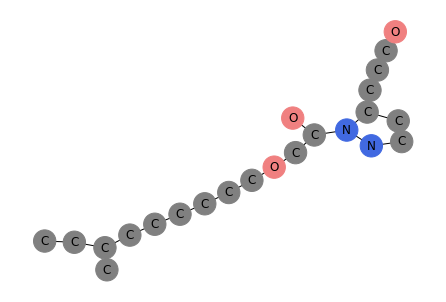

10


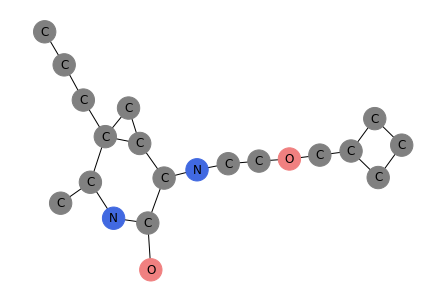

11


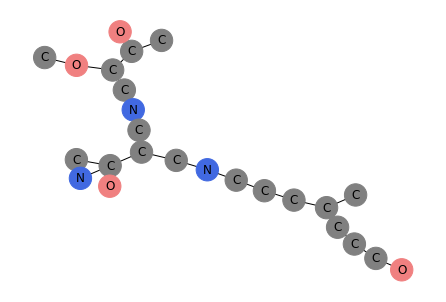

12


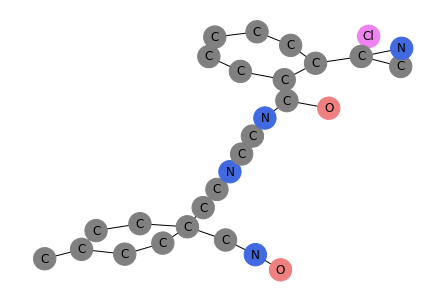

13


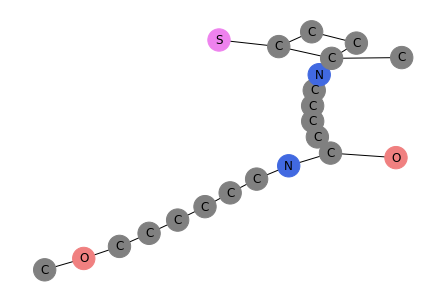

14


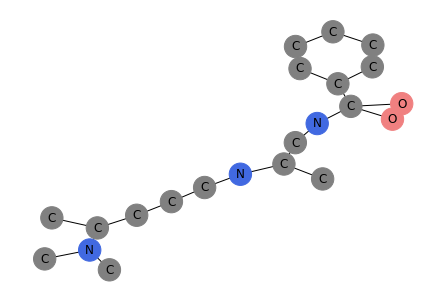

15


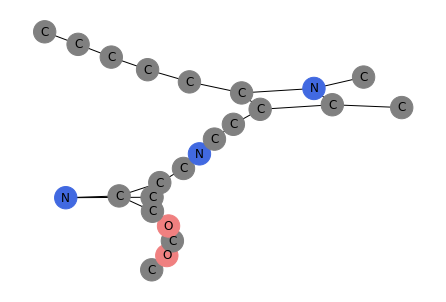

16


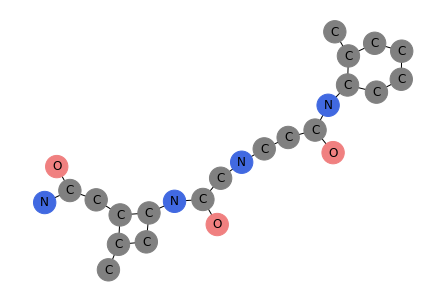

17


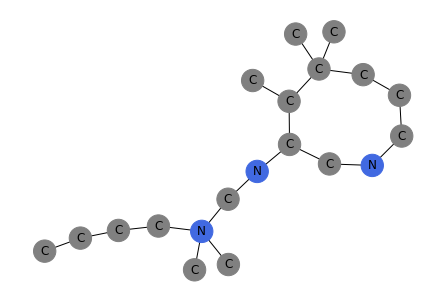

18


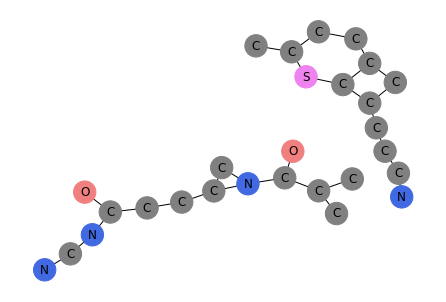

19


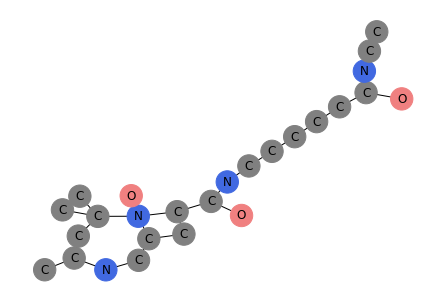

In [8]:
# Plot some randomly generated graphs
for i, g in enumerate(graphs[:20]):
    print(i)
    plot_molecule(g)

### Controllable generation

In [9]:
prior = sample_prior()

# Try and form an indole-like compound
# TODO: this is still rather inefficient
all_edges_inds = graph_conversions.edge_vector_to_pyg_data(prior, 1, reflect=False)
all_edges_vec = graph_conversions.pyg_data_to_edge_vector(prior)
assert all_edges_inds.shape[1] == all_edges_vec.shape[0]
retain_mask = torch.full(all_edges_vec.shape, False)
discard_mask = torch.full(all_edges_vec.shape, False)

# Given 8 Cs and 1 N at indices 0 through 8, these are the edges
# that need to be formed
indole_edges = [
    (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (0, 8), (2, 7)
]

for i in range(len(prior.ptr) - 1):
    start, end = prior.ptr[i], prior.ptr[i + 1]
    
    # Pick 8 Cs and 1 N
    c_mask = (prior.x[start:end][:, 0] == 1).cpu().numpy()
    c_inds = np.where(c_mask)[0]
    n_mask = (prior.x[start:end][:, 1] == 1).cpu().numpy()
    n_inds = np.where(n_mask)[0]
    if len(c_inds) < 8 or len(n_inds) < 1:
        # Not enough desired atoms; ignore this one
        continue
    
    atom_inds = np.concatenate([c_inds[:8], n_inds[:1]])  # Arbitrarily take the first indices
    for j_1 in range(9):
        for j_2 in range(j_1):
            ind_1 = atom_inds[j_1] + start
            ind_2 = atom_inds[j_2] + start
            if ind_2 < ind_1:
                ind_1, ind_2 = ind_2, ind_1
            m = (all_edges_inds[0, :] == ind_1) & (all_edges_inds[1, :] == ind_2)
            assert torch.sum(m).item() == 1
            if (j_2, j_1) in indole_edges:
                retain_mask[m] = True
            else:
                discard_mask[m] = True
            
# Go through sampling procedure
samples = [prior]
data_t = prior
for t in tqdm.notebook.trange(t_limit, 0, -1):
    data_t = generate.generate_graph_samples(
        model, diffuser, data_t, t_limit=t, t_start=(t - 1)
    )
    
    # Make sure the edges we want to exist will exist
    edges_t = graph_conversions.pyg_data_to_edge_vector(data_t)
    edges_t[retain_mask] = 1
    edges_t[discard_mask] = 0
    data_t.edge_index = graph_conversions.edge_vector_to_pyg_data(prior, edges_t)
    
    samples.append(data_t)

graph_samples = [
    graph_conversions.split_pyg_data_to_nx_graphs(sample)
    for sample in tqdm.notebook.tqdm(samples)
]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

0


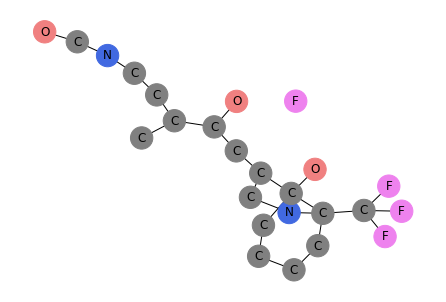

1


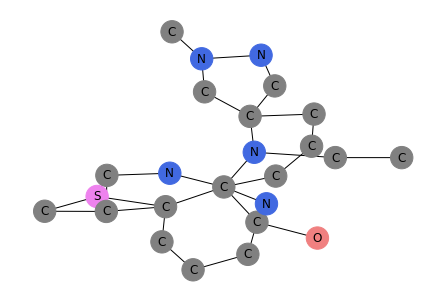

2


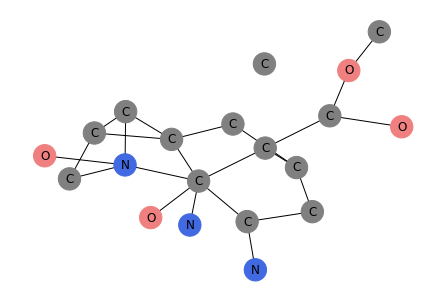

3


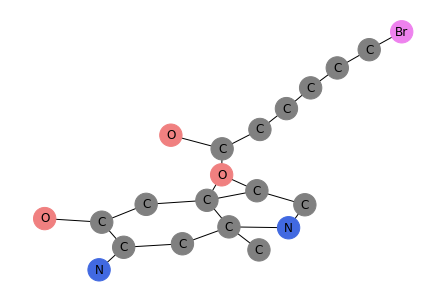

4


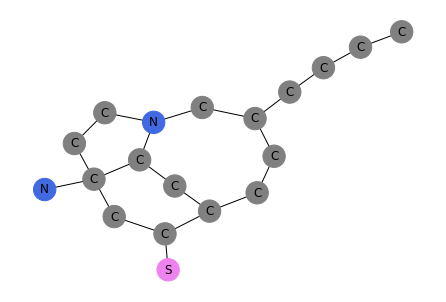

5


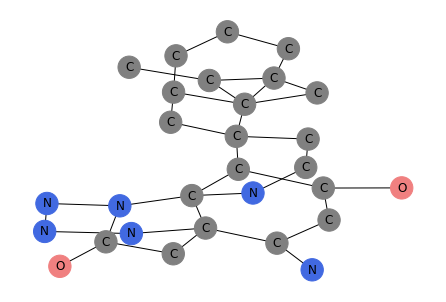

6


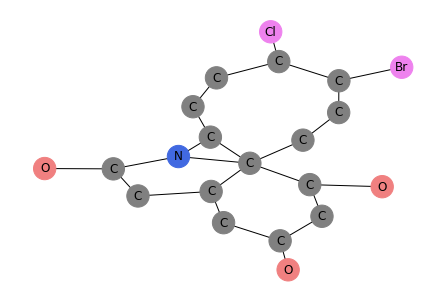

7


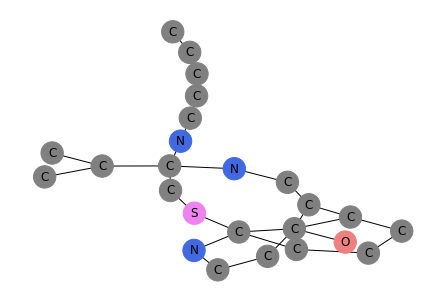

8


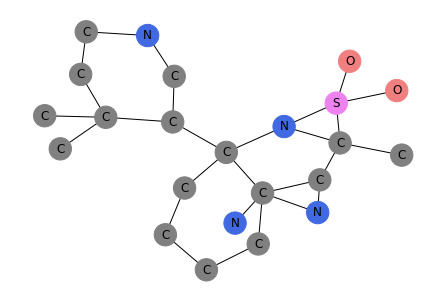

9


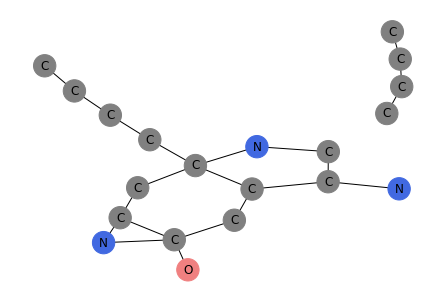

10


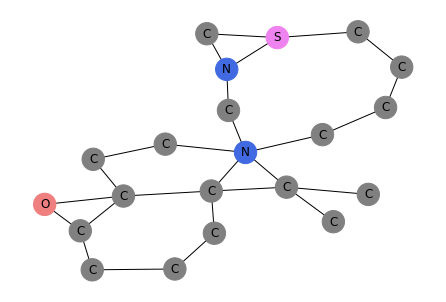

11


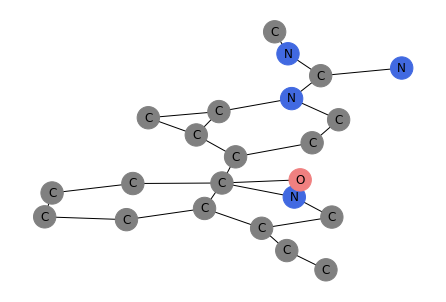

12


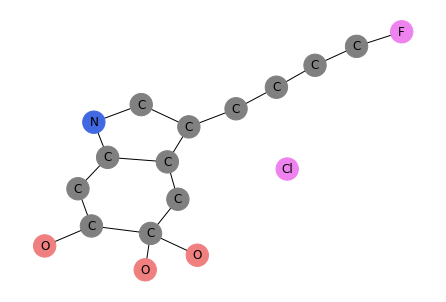

13


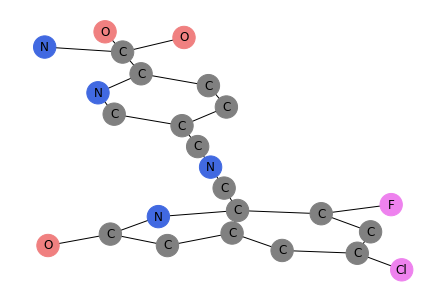

14


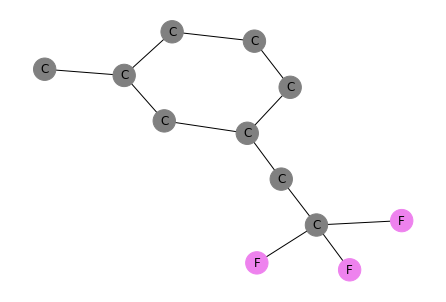

15


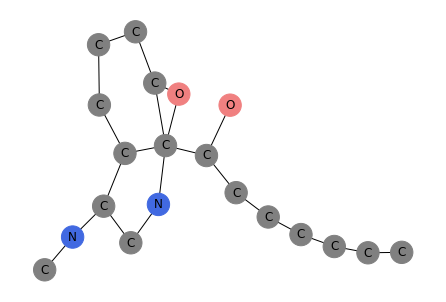

16


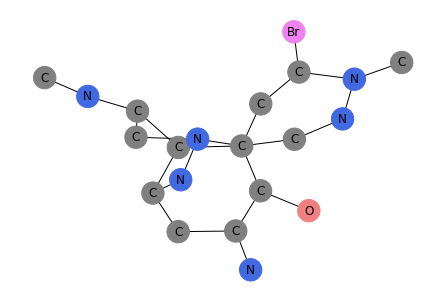

17


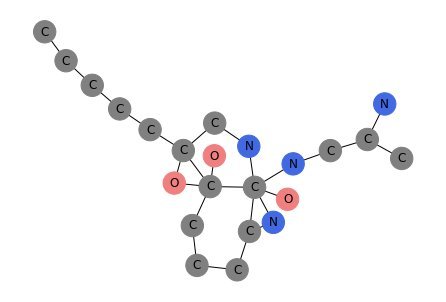

18


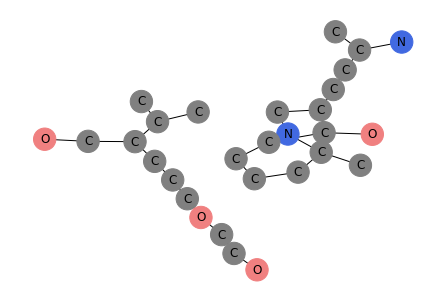

19


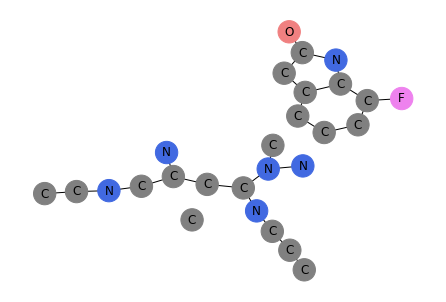

20


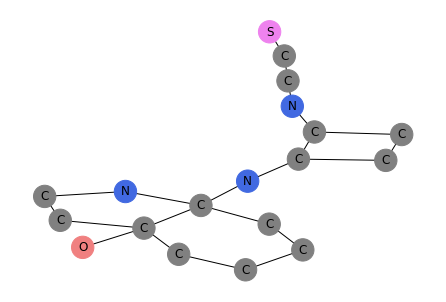

21


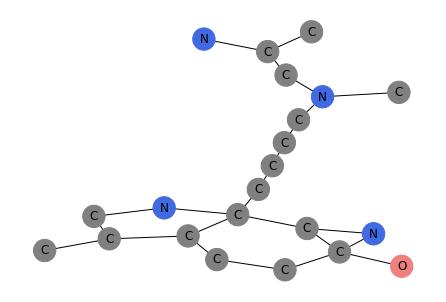

22


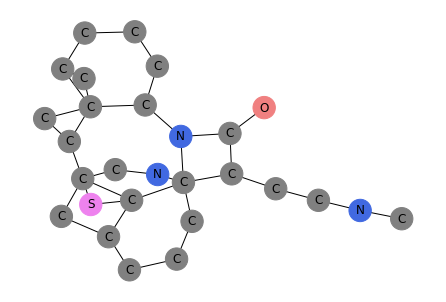

23


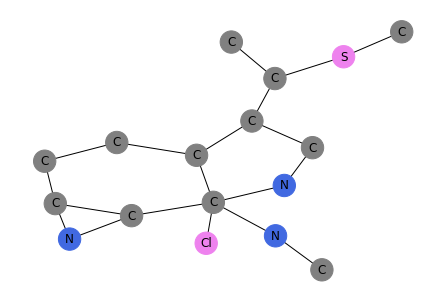

24


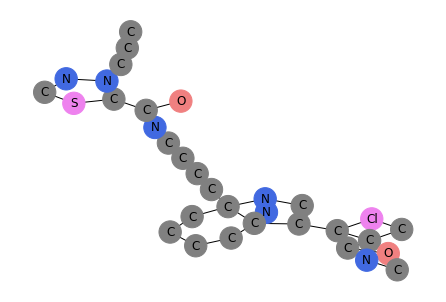

25


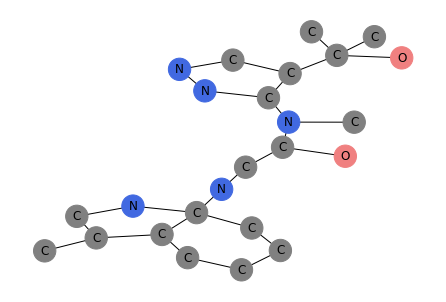

26


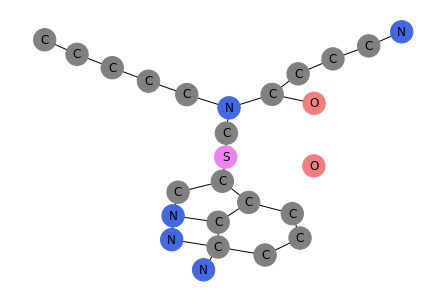

27


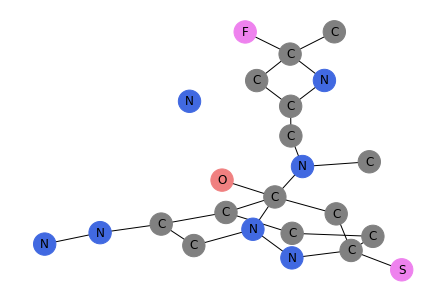

28


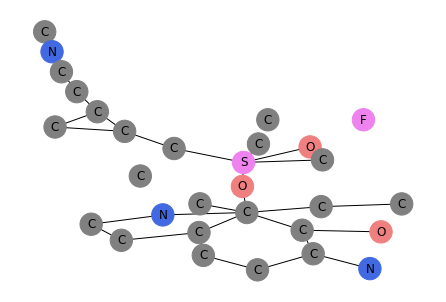

29


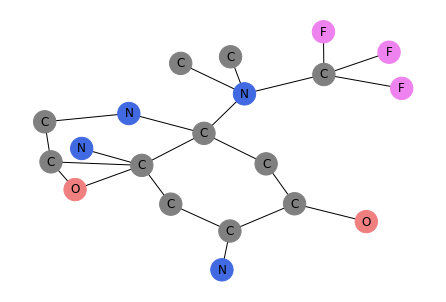

30


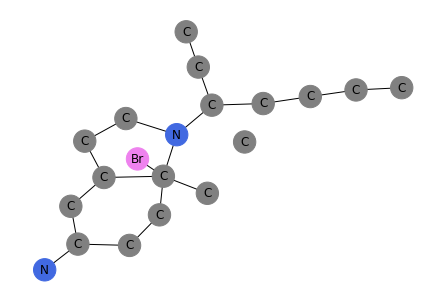

31


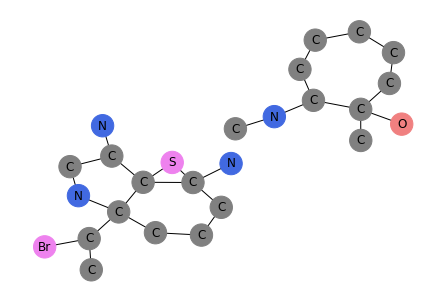

In [10]:
# Plot some randomly generated graphs
for i in range(len(graph_samples[-1])):
    print(i)
    g = graph_samples[-1][i]
    plot_molecule(g)